Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4297 entries, 0 to 4296
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SettlementValue           4297 non-null   float64
 1   AccidentType              4226 non-null   object 
 2   InjuryPrognosis           4297 non-null   int64  
 3   SpecialHealthExpenses     4297 non-null   float64
 4   SpecialReduction          4297 non-null   float64
 5   SpecialOverage            4297 non-null   float64
 6   GeneralRest               4297 non-null   float64
 7   SpecialAdditionalInjury   4297 non-null   float64
 8   SpecialEarningsLoss       4297 non-null   float64
 9   SpecialUsageLoss          4297 non-null   float64
 10  SpecialMedications        4297 non-null   float64
 11  SpecialAssetDamage        4297 non-null   float64
 12  SpecialRehabilitation     4297 non-null   float64
 13  SpecialFixes              4297 non-null   flo

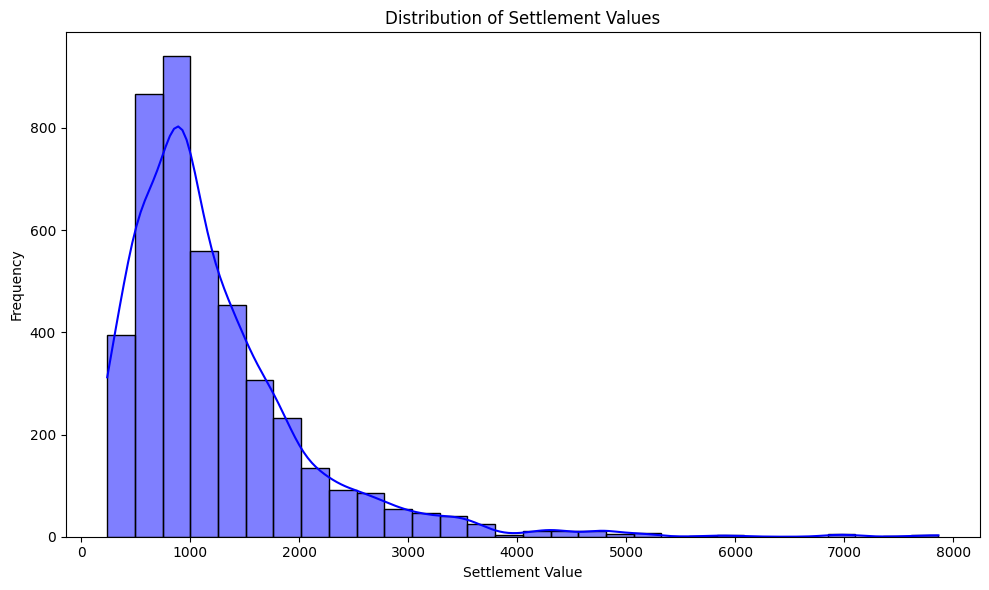

In [1]:
# Import necessary libraries
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


# Load the processed claim data
data_path = 'ProcessedClaimData.csv' 
claim_data = pd.read_csv(data_path)

# Display basic information about the dataset
print("Dataset Overview:")
print(claim_data.info())
print("\nFirst 5 rows of the dataset:")
print(claim_data.head())

# Check for missing values
missing_values = claim_data.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])

# Basic statistics of numerical columns
print("\nBasic statistics of numerical columns:")
print(claim_data.describe())

# Visualize the distribution of the target variable
target_col = 'SettlementValue'
plt.figure(figsize=(10, 6))
sns.histplot(claim_data[target_col], kde=True, bins=30, color='blue')
plt.title('Distribution of Settlement Values')
plt.xlabel('Settlement Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Original Settlement Value statistics:
count    4297.000000
mean     1218.505187
std       858.286445
min       240.000000
25%       670.000000
50%       989.000000
75%      1515.000000
max      7862.900000
Name: SettlementValue, dtype: float64

Log-transformed Settlement Value statistics:
count    4297.000000
mean        6.900062
std         0.649392
min         5.484797
25%         6.508769
50%         6.897705
75%         7.323831
max         8.970038
Name: LogSettlementValue, dtype: float64


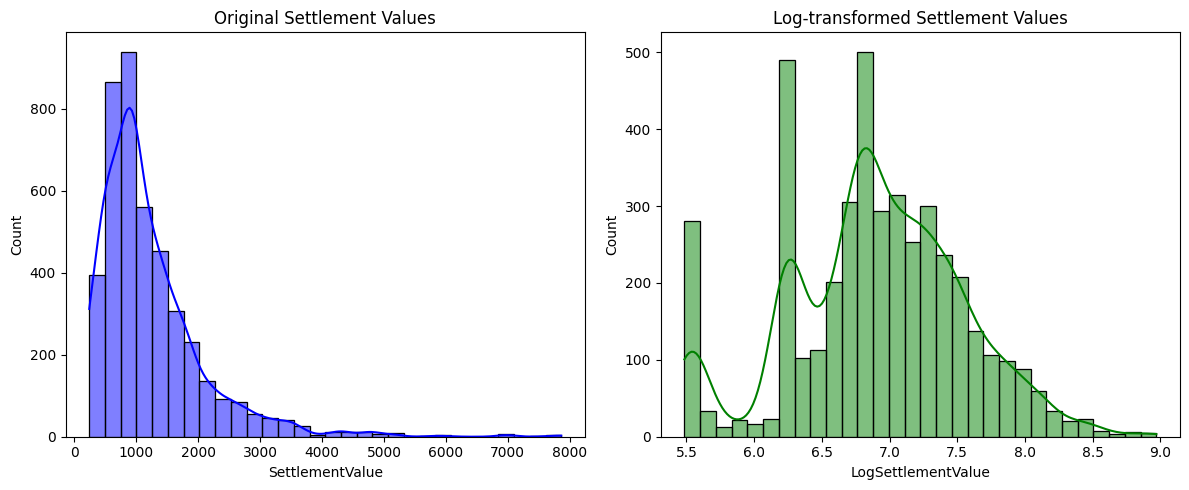

In [2]:
# Apply log transformation to the target variable
claim_data['LogSettlementValue'] = np.log1p(claim_data[target_col])
print("Original Settlement Value statistics:")
print(claim_data[target_col].describe())
print("\nLog-transformed Settlement Value statistics:")
print(claim_data['LogSettlementValue'].describe())

# Update target column to use log-transformed values
original_target_col = target_col
target_col = 'LogSettlementValue'

# Visualize the transformation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(claim_data[original_target_col], kde=True, bins=30, color='blue')
plt.title('Original Settlement Values')
plt.subplot(1, 2, 2)
sns.histplot(claim_data[target_col], kde=True, bins=30, color='green')
plt.title('Log-transformed Settlement Values')
plt.tight_layout()
plt.show()

In [3]:
# Function to identify categorical and numerical columns (same as model_comparison.ipynb)
def identify_columns(data):
    # Identify categorical and numerical columns
    categorical_cols = data.select_dtypes(include=['object', 'string']).columns.tolist()
    numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Remove the target variable from the feature lists
    target_col = 'LogSettlementValue'
    
    # Remove both the log-transformed target AND the original settlement value from features
    if target_col in numerical_cols:
        numerical_cols.remove(target_col)
    if 'SettlementValue' in numerical_cols: 
        numerical_cols.remove('SettlementValue') 
    
    return categorical_cols, numerical_cols, target_col

# Define preprocessor function (similar to model_comparison.ipynb)
def define_preprocessor(data):
    categorical_cols, numerical_cols, _ = identify_columns(data)
    
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Handle missing numerical values with median
        ('scaler', StandardScaler())                    # Standardize numerical features
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing categorical values
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )
    
    return preprocessor, numerical_cols, categorical_cols

# Get categorical and numerical columns
categorical_cols, numerical_cols, target_col = identify_columns(claim_data)
print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")
print(f"Target column: {target_col}")


Categorical columns: ['AccidentType', 'DominantInjury', 'VehicleType', 'WeatherConditions', 'AccidentDescription', 'InjuryDescription', 'Gender']
Numerical columns: ['InjuryPrognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances', 'MinorPsychologicalInjury', 'Whiplash', 'AccidentDate', 'ClaimDate', 'VehicleAge', 'DriverAge', 'NumberOfPassengers', 'PoliceReportFiled', 'WitnessPresent']
Target column: LogSettlementValue


# Feature Selection Pipeline: XGBoost vs Random Forest
This section implements a pipeline to compare XGBoost and Random Forest for feature selection, then selects the better performing model for determining the top 10 features.

Start comparing feature selection models...

1. Training and evaluating Random Forest model...
Random Forest MSE: 0.0342 (±0.0063)
Random Forest training time: 14.58 seconds

2. Training and evaluating XGBoost model...
XGBoost MSE: 0.0318 (±0.0044)
XGBoost training time: 0.72 seconds

3. Comparing models:
           Model       MSE       Std  Training Time (s)
0  Random Forest  0.034198  0.006271          14.576064
1        XGBoost  0.031754  0.004385           0.717359

Best model for feature selection: XGBoost


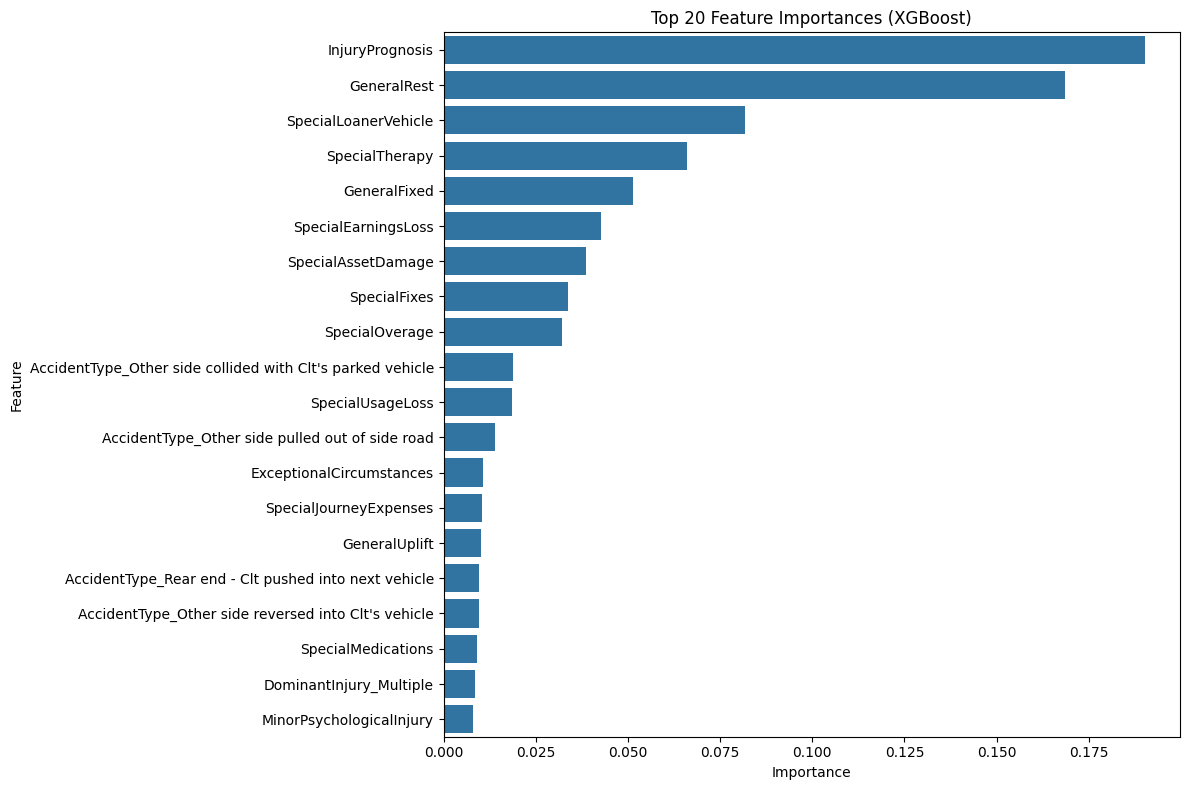


Selected top 10 features using XGBoost:
['InjuryPrognosis' 'GeneralRest' 'SpecialLoanerVehicle' 'SpecialTherapy'
 'GeneralFixed' 'SpecialEarningsLoss' 'SpecialAssetDamage' 'SpecialFixes'
 'SpecialOverage'
 "AccidentType_Other side collided with Clt's parked vehicle"]

Number of common features in top 20: 14 out of 20
Common features: {'SpecialUsageLoss', 'SpecialFixes', 'SpecialJourneyExpenses', 'SpecialOverage', 'SpecialTherapy', 'AccidentType_Other side pulled out of side road', 'GeneralFixed', 'SpecialLoanerVehicle', 'InjuryPrognosis', 'SpecialEarningsLoss', 'GeneralRest', 'MinorPsychologicalInjury', 'GeneralUplift', 'SpecialAssetDamage'}


In [4]:
# Prepare data for the feature selection models
X = claim_data.drop(columns=[target_col, 'SettlementValue'])
y = claim_data[target_col].values

# Create and fit the preprocessor for features
preprocessor, numerical_cols, categorical_cols = define_preprocessor(claim_data)
X_processed = preprocessor.fit_transform(X)

# Get feature names after preprocessing
feature_names = []
feature_names.extend(numerical_cols)
if categorical_cols:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(categorical_cols)
    feature_names.extend(cat_feature_names)

print("Start comparing feature selection models...")

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 1. Train and evaluate Random Forest
print("\n1. Training and evaluating Random Forest model...")
import time
start_time_rf = time.time()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Cross-validation for Random Forest
rf_scores = cross_val_score(rf_model, X_processed, y, cv=cv, scoring='neg_mean_squared_error')
rf_mse = -rf_scores.mean()
rf_std = rf_scores.std()

# Fit Random Forest on the full dataset for feature importance
rf_model.fit(X_processed, y)
rf_importances = rf_model.feature_importances_
end_time_rf = time.time()
rf_time = end_time_rf - start_time_rf

# Create a DataFrame for Random Forest feature importances
rf_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values('Importance', ascending=False)

print(f"Random Forest MSE: {rf_mse:.4f} (±{rf_std:.4f})")
print(f"Random Forest training time: {rf_time:.2f} seconds")

# 2. Train and evaluate XGBoost
print("\n2. Training and evaluating XGBoost model...")
start_time_xgb = time.time()
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Cross-validation for XGBoost
xgb_scores = cross_val_score(xgb_model, X_processed, y, cv=cv, scoring='neg_mean_squared_error')
xgb_mse = -xgb_scores.mean()
xgb_std = xgb_scores.std()

# Fit XGBoost on the full dataset for feature importance
xgb_model.fit(X_processed, y)
xgb_importances = xgb_model.feature_importances_
end_time_xgb = time.time()
xgb_time = end_time_xgb - start_time_xgb

# Create a DataFrame for XGBoost feature importances
xgb_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
}).sort_values('Importance', ascending=False)

print(f"XGBoost MSE: {xgb_mse:.4f} (±{xgb_std:.4f})")
print(f"XGBoost training time: {xgb_time:.2f} seconds")

# 3. Compare the models and select the better one
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'MSE': [rf_mse, xgb_mse],
    'Std': [rf_std, xgb_std],
    'Training Time (s)': [rf_time, xgb_time]
})
print("\n3. Comparing models:")
print(model_comparison)

# Determine the better model based on MSE
best_model_name = model_comparison.loc[model_comparison['MSE'].idxmin(), 'Model']
print(f"\nBest model for feature selection: {best_model_name}")

# Select the feature importance from the better model
if best_model_name == 'Random Forest':
    best_feature_importance = rf_feature_importance
    model_name_short = 'RF'
else:
    best_feature_importance = xgb_feature_importance
    model_name_short = 'XGB'

# Visualize the top 20 features from the better model
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=best_feature_importance.head(20))
plt.title(f'Top 20 Feature Importances ({best_model_name})')
plt.tight_layout()
plt.show()

# Select the top 10 features from the better model
top_10_features = best_feature_importance.head(10)['Feature'].values
print(f"\nSelected top 10 features using {best_model_name}:")
print(top_10_features)

# Compare feature rankings between the two models
# Get top 20 features from each model
rf_top20 = rf_feature_importance.head(20)['Feature'].tolist()
xgb_top20 = xgb_feature_importance.head(20)['Feature'].tolist()

# Count features in both lists (common features)
common_features = set(rf_top20).intersection(set(xgb_top20))
print(f"\nNumber of common features in top 20: {len(common_features)} out of 20")
print("Common features:", common_features)

# Get the indices of the top 10 features in the processed data
top_10_indices = [i for i, feature in enumerate(feature_names) if feature in top_10_features]

# Save the feature selection results
feature_selection_results = {
    'best_model': best_model_name,
    'rf_mse': rf_mse,
    'xgb_mse': xgb_mse,
    'top_10_features': top_10_features.tolist(),
    'top_10_indices': top_10_indices,
    'common_features_in_top20': list(common_features)
}

# Prepare Data for PyTorch
Now that we have identified the top 10 features, we'll split the data into training, validation, and test sets and prepare it for neural network training.

In [5]:
# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Apply preprocessing to the data
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Filter to include only the top 10 features selected by the best model
X_train_processed_top10 = X_train_processed[:, top_10_indices]
X_val_processed_top10 = X_val_processed[:, top_10_indices]
X_test_processed_top10 = X_test_processed[:, top_10_indices]

# Convert to PyTorch tensors using the selected top 10 features
X_train_tensor = torch.tensor(X_train_processed_top10, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_processed_top10, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_processed_top10, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader objects for PyTorch
from torch.utils.data import DataLoader, TensorDataset
batch_size = 48
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes and shapes with top 10 features
print(f"\nTraining set size: {len(train_dataset)} samples, Features shape (top 10): {X_train_processed_top10.shape}")
print(f"Validation set size: {len(val_dataset)} samples, Features shape (top 10): {X_val_processed_top10.shape}")
print(f"Test set size: {len(test_dataset)} samples, Features shape (top 10): {X_test_processed_top10.shape}")


Training set size: 2577 samples, Features shape (top 10): (2577, 10)
Validation set size: 860 samples, Features shape (top 10): (860, 10)
Test set size: 860 samples, Features shape (top 10): (860, 10)


# Build and Train Neural Network Model
Implement a PyTorch neural network model for regression using the top 10 features with early stopping.

In [6]:
class InsuranceLoss(nn.Module):
    def __init__(self, underestimation_weight=2.0, claim_threshold=2500):
        super(InsuranceLoss, self).__init__()
        self.underestimation_weight = underestimation_weight
        self.claim_threshold = claim_threshold
        
    def forward(self, predictions, targets):
        # Calculate error
        errors = targets - predictions
        
        # Progressive penalty that scales with claim value
        high_value_factor = torch.clamp(targets / self.claim_threshold, min=1.0, max=3.0)
        
        # Weighted errors: penalize underestimation more for higher values
        weights = torch.ones_like(errors)
        underestimation_mask = (errors > 0)
        
        # Apply stronger underestimation penalty for high-value claims
        weights[underestimation_mask] = self.underestimation_weight * high_value_factor[underestimation_mask]
        
        # Calculate weighted squared errors with gradient clipping
        weighted_squared_errors = errors.pow(2) * weights
        
        return weighted_squared_errors.mean()


class BalancedInsuranceLoss(nn.Module):
    def __init__(self):
        super(BalancedInsuranceLoss, self).__init__()
        
    def forward(self, predictions, targets):
        # Basic squared error
        squared_error = (predictions - targets)**2
        
        # Calculate relative error for percentage-based weighting
        relative_error = torch.abs(predictions - targets) / (targets + 1e-8)
        
        # Weight higher for both very low and very high values
        value_weight = 1.0 + torch.exp(-0.0005 * (targets - 2000)**2)
        
        # Calculate direction bias - penalize underestimation of high values and 
        # overestimation of low values
        high_value_mask = (targets > 2000).float()
        direction_penalty = high_value_mask * (targets > predictions).float() + \
                           (1 - high_value_mask) * (predictions > targets).float()
        
        # Combine all factors
        loss = squared_error * (1.0 + 0.2 * relative_error) * (1.0 + 0.15 * direction_penalty) * value_weight
        
        return loss.mean()

def detect_outliers(data, threshold=3.0):
    """
    Simple outlier detection using z-score method.
    Returns a tensor mask where True indicates an outlier.
    """
    with torch.no_grad():
        # Compute z-scores
        mean = torch.mean(data)
        std = torch.std(data)
        z_scores = torch.abs((data - mean) / (std + 1e-8))
        
        # Create outlier mask where z-score exceeds threshold
        outlier_mask = z_scores > threshold
    
    return outlier_mask

class OutlierAwareLoss(nn.Module):
    def __init__(self, outlier_weight=0.3, threshold=3.0):
        super(OutlierAwareLoss, self).__init__()
        self.outlier_weight = outlier_weight  # Weight for outliers (smaller than 1.0)
        self.threshold = threshold
        
    def forward(self, predictions, targets):
        # Detect outliers in target values
        outlier_mask = detect_outliers(targets, self.threshold)
        
        # Calculate squared errors
        squared_errors = (targets - predictions).pow(2)
        
        # Assign different weights to outliers and non-outliers
        weights = torch.ones_like(squared_errors)
        weights[outlier_mask] = self.outlier_weight  # Reduce weight for outliers
        
        # Apply weights to squared errors
        weighted_squared_errors = squared_errors * weights
        
        return weighted_squared_errors.mean()
    
class RobustHuberLoss(nn.Module):
    def __init__(self, delta=1.0, scale_factor=3.0):
        super(RobustHuberLoss, self).__init__()
        self.delta = delta
        self.scale_factor = scale_factor  # Increase penalty for underprediction
        
    def forward(self, predictions, targets):
        errors = targets - predictions
        abs_errors = torch.abs(errors)
        
        # Apply Huber loss with different weights for under vs over prediction
        weights = torch.ones_like(errors)
        # Higher weight for underpredicting high values
        underprediction = (errors > 0) & (targets > 7.5)  # log(1800) ≈ 7.5
        weights[underprediction] = self.scale_factor
        
        # Standard Huber loss calculation with weights
        quadratic = torch.min(abs_errors, torch.tensor(self.delta).to(errors.device))
        linear = abs_errors - quadratic
        loss = 0.5 * quadratic.pow(2) + self.delta * linear
        
        return (loss * weights).mean()

Using device: mps
Using device: mps


/Users/far/Desktop/desd/desd_1/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/160, Train Loss: 48.3906, Val Loss: 37.1236
  Found new best model with validation loss: 37.1236 (improved by 0.00%)
Epoch 2/160, Train Loss: 25.9133, Val Loss: 15.8349
  Found new best model with validation loss: 15.8349 (improved by 57.35%)
Epoch 3/160, Train Loss: 7.8639, Val Loss: 1.4864
  Found new best model with validation loss: 1.4864 (improved by 90.61%)
Epoch 4/160, Train Loss: 1.6869, Val Loss: 1.0278
  Found new best model with validation loss: 1.0278 (improved by 30.85%)
Epoch 5/160, Train Loss: 1.1954, Val Loss: 0.5730
  Found new best model with validation loss: 0.5730 (improved by 44.25%)
Epoch 6/160, Train Loss: 0.9091, Val Loss: 0.6220
Epoch 7/160, Train Loss: 0.7112, Val Loss: 0.4204
  Found new best model with validation loss: 0.4204 (improved by 26.63%)
Epoch 8/160, Train Loss: 0.6173, Val Loss: 0.4376
Epoch 9/160, Train Loss: 0.5103, Val Loss: 0.5498
Epoch 10/160, Train Loss: 0.4286, Val Loss: 0.4587
Epoch 11/160, Train Loss: 0.3879, Val Loss: 0.3258
  Fou

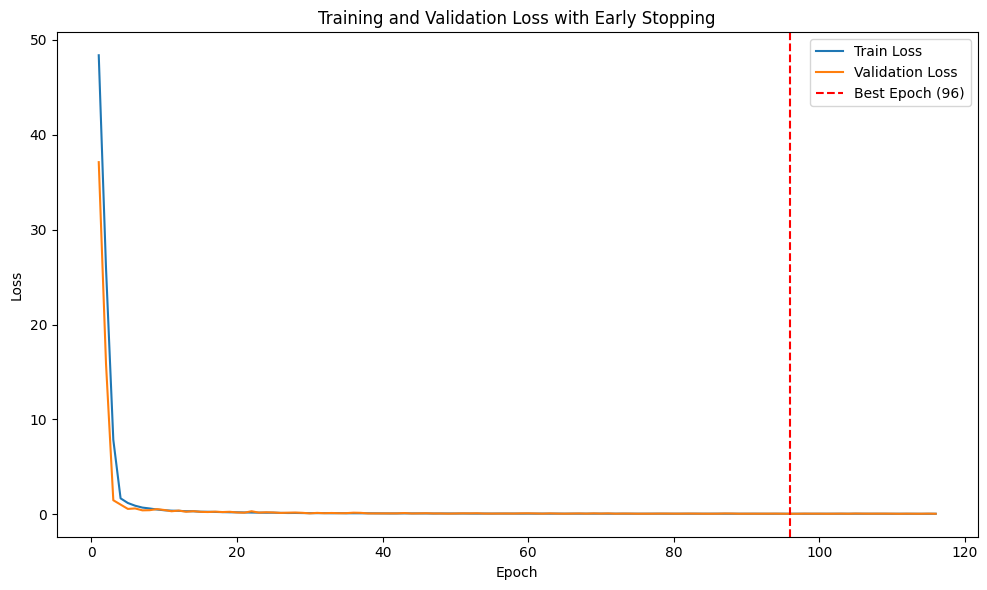

In [7]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Define the PyTorch neural network model for top 10 features
# More balanced neural network that avoids over-correction
# Check if MPS (Metal Performance Shaders) backend is available for Apple Silicon
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Neural network with slight improvements to capture high-value claims better
class InsuranceNN(nn.Module):
    def __init__(self, input_size):
        super(InsuranceNN, self).__init__()
        # Main branch with deeper layers
        self.main_branch = nn.Sequential(
            nn.Linear(input_size, 48),
            nn.ReLU(),
            nn.BatchNorm1d(48),
            nn.Dropout(0.25),
            
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.BatchNorm1d(24),
            nn.Dropout(0.2),
            
            nn.Linear(24, 12),
            nn.ReLU(),
            nn.BatchNorm1d(12),
            nn.Dropout(0.1),
        )
        
        # Separate high-value branch with fewer layers
        self.high_value_branch = nn.Sequential(
            nn.Linear(input_size, 24),
            nn.ReLU(),
            nn.BatchNorm1d(24),
            nn.Linear(24, 12),
            nn.ReLU(),
        )
        
        # Combine both branches
        self.final_layer = nn.Linear(24, 1)
        
        # Better initialization
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, x):
        main_output = self.main_branch(x)
        high_value_output = self.high_value_branch(x)
        combined = torch.cat((main_output, high_value_output), dim=1)
        return self.final_layer(combined)

# Initialize the model
input_size = X_train_tensor.shape[1]  
model = InsuranceNN(input_size).to(device)

# Modest optimization settings
# Use the outlier-aware loss function
criterion = OutlierAwareLoss(outlier_weight=0.5, threshold=3.0).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Slightly adjusted scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.75,
    patience=12, 
    verbose=True,
    min_lr=1e-5
)

# Batch size and dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training settings
num_epochs = 160  # Slightly more epochs
early_stopping_patience = 20
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []
best_epoch = 0

# Training loop with early stopping
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        
        # Gentle gradient clipping 
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)
        
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    # Update learning rate
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping logic with best model tracking
    if val_loss < best_val_loss:
        improvement = (best_val_loss - val_loss) / best_val_loss * 100 if best_val_loss != float('inf') else 0
        best_val_loss = val_loss
        best_epoch = epoch + 1
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"  Found new best model with validation loss: {val_loss:.4f} (improved by {improvement:.2f}%)")
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered. Best epoch was {best_epoch}")
            break

# Load the best model
print("\nLoading best model from checkpoint...")
model.load_state_dict(best_model_state)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss with Early Stopping")
plt.legend()
plt.tight_layout()
plt.show()

Test Loss (MSE in log space): 0.0565
Test R² (in log space): 0.8633


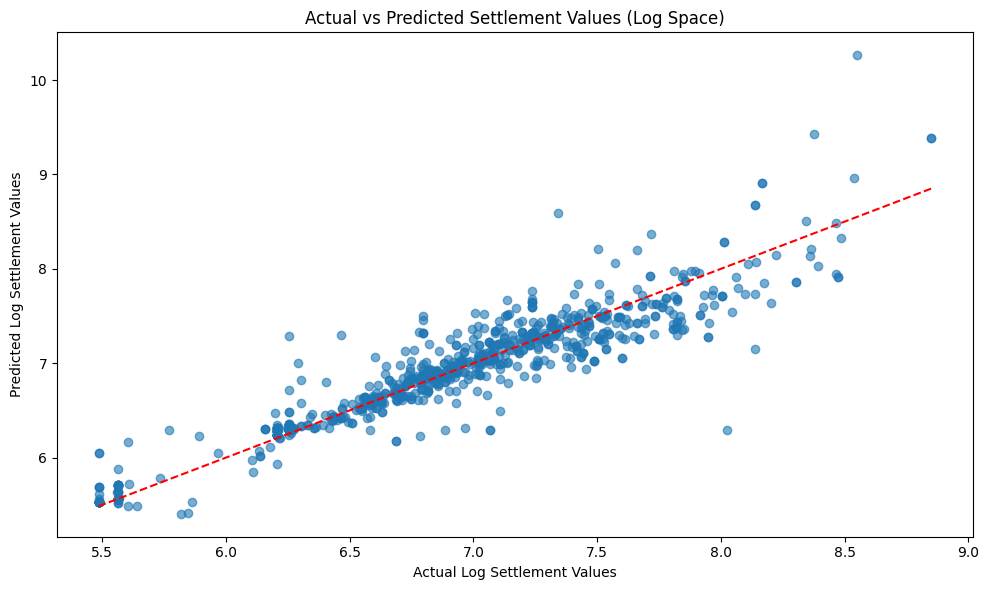

In [8]:
# Evaluate the model on the test set in log space
model.eval()
test_loss = 0.0
predictions_list = []
actuals_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item() * X_batch.size(0)

        predictions_list.extend(predictions.cpu().numpy())
        actuals_list.extend(y_batch.cpu().numpy())

test_loss /= len(test_loader.dataset)
test_r2 = r2_score(actuals_list, predictions_list)
print(f"Test Loss (MSE in log space): {test_loss:.4f}")
print(f"Test R² (in log space): {test_r2:.4f}")


# Plot actual vs predicted values in log space
plt.figure(figsize=(10, 6))
plt.scatter(actuals_list, predictions_list, alpha=0.6)
plt.plot([min(actuals_list), max(actuals_list)], [min(actuals_list), max(actuals_list)], 'r--')
plt.xlabel("Actual Log Settlement Values")
plt.ylabel("Predicted Log Settlement Values")
plt.title("Actual vs Predicted Settlement Values (Log Space)")
plt.tight_layout()
plt.show()

Errors in GBP (£):
MSE: £982809.23
RMSE: £991.37
MAE: £269.41
MAPE: 15.97%
R²: -0.3757


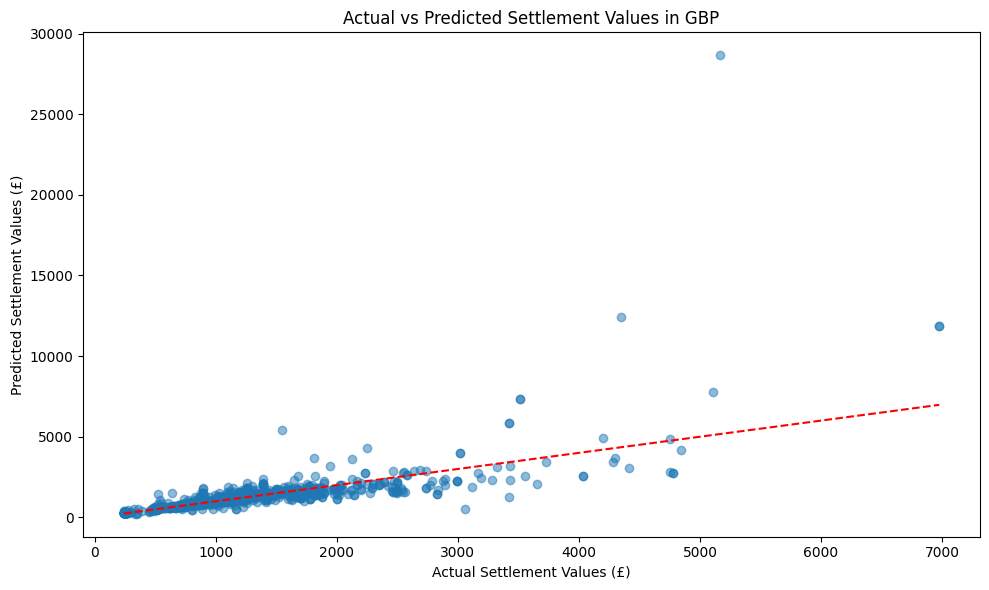

In [9]:
def evaluate_model_in_gbp(model, data_loader, device):
    """
    Evaluate the model and report errors in GBP (pounds)
    """
    model.eval()
    actual_gbp = []
    predicted_gbp = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # # Get predictions
            # predictions = model(X_batch)
            
            # y_gbp = y_batch.cpu().numpy()
            # pred_gbp = predictions.cpu().numpy()
            
            # actual_gbp.extend(y_gbp)
            # predicted_gbp.extend(pred_gbp)
        # Get predictions
            predictions = model(X_batch)
            # Store predictions and actual values
            # Apply inverse log transformation to convert back to GBP
            y_gbp = np.expm1(y_batch.cpu().numpy())
            pred_gbp = np.expm1(predictions.cpu().numpy())
    
            actual_gbp.extend(y_gbp)
            predicted_gbp.extend(pred_gbp)

    # Calculate error metrics in GBP
    mse_gbp = mean_squared_error(actual_gbp, predicted_gbp)
    rmse_gbp = np.sqrt(mse_gbp)
    mae_gbp = mean_absolute_error(actual_gbp, predicted_gbp)
    mape_gbp = np.mean(np.abs((np.array(actual_gbp) - np.array(predicted_gbp)) / np.array(actual_gbp))) * 100
    r2_gbp = r2_score(actual_gbp, predicted_gbp)
    
    print("Errors in GBP (£):")
    print(f"MSE: £{mse_gbp:.2f}")
    print(f"RMSE: £{rmse_gbp:.2f}")
    print(f"MAE: £{mae_gbp:.2f}")
    print(f"MAPE: {mape_gbp:.2f}%")
    print(f"R²: {r2_gbp:.4f}")
    
    return {
        'MSE_GBP': mse_gbp,
        'RMSE_GBP': rmse_gbp,
        'MAE_GBP': mae_gbp,
        'MAPE_GBP': mape_gbp,
        'R2_GBP': r2_gbp,
        'actual_gbp': actual_gbp,
        'predicted_gbp': predicted_gbp
    }

# Call this function to evaluate on test set
gbp_metrics = evaluate_model_in_gbp(model, test_loader, device)

# Visualize predictions in GBP
plt.figure(figsize=(10, 6))
plt.scatter(gbp_metrics['actual_gbp'], gbp_metrics['predicted_gbp'], alpha=0.5)
plt.plot([min(gbp_metrics['actual_gbp']), max(gbp_metrics['actual_gbp'])], 
         [min(gbp_metrics['actual_gbp']), max(gbp_metrics['actual_gbp'])], 'r--')
plt.xlabel('Actual Settlement Values (£)')
plt.ylabel('Predicted Settlement Values (£)')
plt.title('Actual vs Predicted Settlement Values in GBP')
plt.tight_layout()
plt.show()

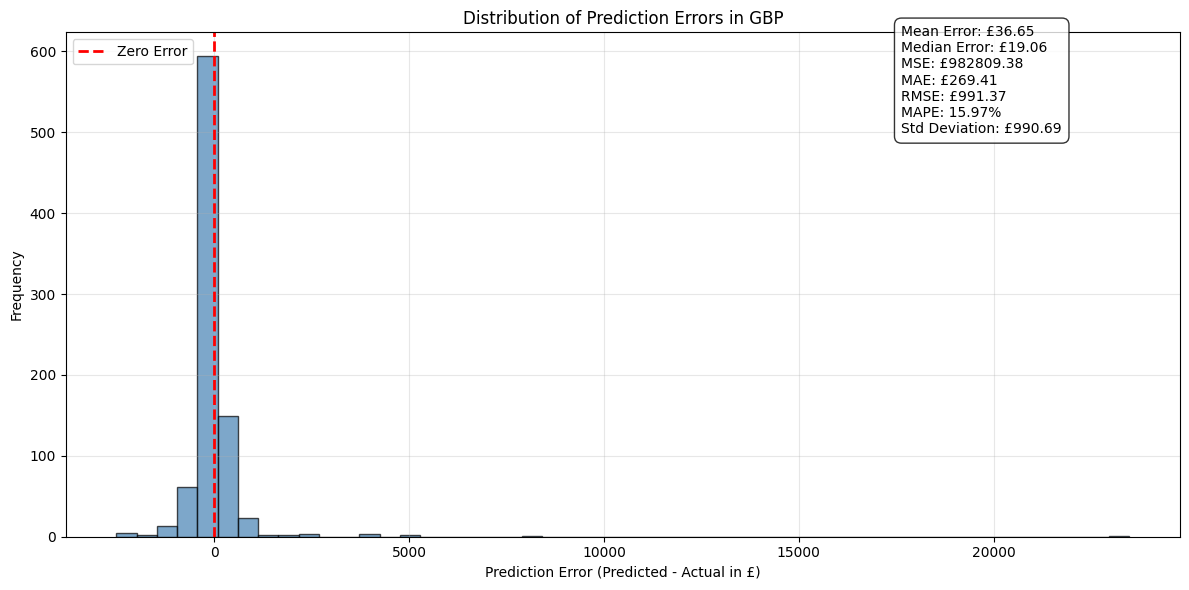

Error Analysis Complete!
Mean Absolute Error (MAE): £269.41
Root Mean Squared Error (RMSE): £991.37
Mean Absolute Percentage Error (MAPE): 15.97%


In [10]:
def analyze_prediction_errors_gbp(actual_gbp, predicted_gbp, figsize=(12, 6), bins=50, 
                                  color='steelblue', show_plot=True, save_path=None):
    """
    Analyze and visualize the errors between predicted and actual values in GBP (pounds).
    
    Parameters:
    -----------
    actual_gbp : array-like
        Actual settlement values in GBP
    predicted_gbp : array-like
        Predicted settlement values in GBP
    figsize : tuple, optional
        Figure size (width, height) in inches
    bins : int, optional
        Number of histogram bins
    color : str, optional
        Color for the histogram bars
    show_plot : bool, optional
        Whether to display the plot
    save_path : str, optional
        Path to save the figure (if None, figure is not saved)
        
    Returns:
    --------
    dict
        Dictionary containing error metrics (mean, median, std, MAE, RMSE)
    """
    # Convert inputs to numpy arrays if they aren't already
    actual_gbp = np.array(actual_gbp).flatten()
    predicted_gbp = np.array(predicted_gbp).flatten()
    
    # Calculate differences
    differences_gbp = predicted_gbp - actual_gbp
    
    # Calculate statistics
    mean_error = np.mean(differences_gbp)
    median_error = np.median(differences_gbp)
    std_error = np.std(differences_gbp)
    mae = np.mean(np.abs(differences_gbp))
    mse = np.mean(np.square(differences_gbp))
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(differences_gbp / actual_gbp)) * 100
    
    # Create a histogram of the differences
    plt.figure(figsize=figsize)
    plt.hist(differences_gbp, bins=bins, alpha=0.7, color=color, edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    
    # Add labels and title
    plt.xlabel('Prediction Error (Predicted - Actual in £)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors in GBP')
    
    # Add statistics to the plot
    stats_text = (f'Mean Error: £{mean_error:.2f}\n'
                  f'Median Error: £{median_error:.2f}\n'
                  f'MSE: £{mse:.2f}\n'
                  f'MAE: £{mae:.2f}\n'
                  f'RMSE: £{rmse:.2f}\n'
                  f'MAPE: {mape:.2f}%\n'
                  f'Std Deviation: £{std_error:.2f}')
    
    plt.annotate(stats_text, xy=(0.75, 0.8), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))
    
    plt.legend()
    plt.tight_layout()
    plt.grid(alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    if show_plot:
        plt.show()
    else:
        plt.close()
    
    # Return error metrics as a dictionary
    return {
        'mean_error': mean_error,
        'median_error': median_error,
        'std_error': std_error,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

# Example usage - add this after evaluating your model with the evaluate_model_in_gbp function
error_metrics = analyze_prediction_errors_gbp(
    gbp_metrics['actual_gbp'], 
    gbp_metrics['predicted_gbp']
)

print("Error Analysis Complete!")
print(f"Mean Absolute Error (MAE): £{error_metrics['mae']:.2f}")
print(f"Root Mean Squared Error (RMSE): £{error_metrics['rmse']:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {error_metrics['mape']:.2f}%")

# Save Final Model

In [11]:
# # # Save the model and related information
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'top_10_features': top_10_features,
#     'feature_importance': best_feature_importance.head(10).to_dict('records'),
#     'best_feature_selection_model': best_model_name,
#     'input_size': input_size,
#     'performance_metrics': {
#         'mse_log': test_loss,
#         'r2_log': test_r2,
#         'mae_gbp': gbp_metrics['MAE_GBP'],
#         'rmse_gbp': gbp_metrics['RMSE_GBP'],
#         'mape_gbp': gbp_metrics['MAPE_GBP'],
#         'r2_gbp': gbp_metrics['R2_GBP']
#     }
# }, 'neural_network_top10_features.pth')

# # print("Model trained on top 10 features saved to 'neural_network_top10_features.pth'")